In [ ]:
#!pip install requirements.txt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C:\Users\Lenovo-ПК\AppData\Local\Temp\ipykernel_10912\1708544450.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("../data/train.csv")
data.head()

Artist Name                             Track Name  Popularity  \
0             Bruno Mars  That's What I Like (feat. Gucci Mane)        60.0   
1                 Boston                           Hitch a Ride        54.0   
2          The Raincoats                     No Side to Fall In        35.0   
3                   Deno             Lingo (feat. J.I & Chunkz)        66.0   
4  Red Hot Chili Peppers      Nobody Weird Like Me - Remastered        53.0   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.854   0.564   1.0    -4.964     1       0.0485      0.017100   
1         0.382   0.814   3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614   6.0    -8.334     1       0.0525      0.486000   
3         0.853   0.597  10.0    -6.528     0       0.0555      0.021200   
4         0.167   0.975   2.0    -4.279     1       0.2160      0.000169   

   instrumentalness  liveness  valence    tempo  duration_in min/ms  \
0               NaN    0.0849   0.8990  134.071            234596.0   
1          0.004010    0.1010   0.5690  116.454            251733.0   
2          0.000196    0.3940   0.7870  147.681            109667.0   
3               NaN    0.1220   0.5690  107.033            173968.0   
4          0.016100    0.1720   0.0918  199.060            229960.0   

   time_signature  Class  
0               4      5  
1               4     10  
2               4      6  
3               4      5  
4               4     10

### EDA:

In [3]:
data.describe()

Popularity  danceability        energy           key      loudness  \
count  17568.000000  17996.000000  17996.000000  15982.000000  17996.000000   
mean      44.512124      0.543433      0.662777      5.952447     -7.910660   
std       17.426928      0.166268      0.235373      3.196854      4.049151   
min        1.000000      0.059600      0.000020      1.000000    -39.952000   
25%       33.000000      0.432000      0.509000      3.000000     -9.538000   
50%       44.000000      0.545000      0.700000      6.000000     -7.016000   
75%       56.000000      0.659000      0.860000      9.000000     -5.189000   
max      100.000000      0.989000      1.000000     11.000000      1.355000   

               mode   speechiness  acousticness  instrumentalness  \
count  17996.000000  17996.000000  17996.000000      13619.000000   
mean       0.636753      0.079707      0.247082          0.177562   
std        0.480949      0.083576      0.310632          0.304048   
min        0.000000      0.022500      0.000000          0.000001   
25%        0.000000      0.034800      0.004300          0.000089   
50%        1.000000      0.047400      0.081400          0.003910   
75%        1.000000      0.083000      0.434000          0.200000   
max        1.000000      0.955000      0.996000          0.996000   

           liveness       valence         tempo  duration_in min/ms  \
count  17996.000000  17996.000000  17996.000000        1.799600e+04   
mean       0.196170      0.486208    122.623294        2.007445e+05   
std        0.159212      0.240195     29.571527        1.119891e+05   
min        0.011900      0.018300     30.557000        5.016500e-01   
25%        0.097500      0.297000     99.620750        1.663370e+05   
50%        0.129000      0.481000    120.065500        2.091600e+05   
75%        0.258000      0.672000    141.969250        2.524900e+05   
max        1.000000      0.986000    217.416000        1.477187e+06   

       time_signature         Class  
count    17996.000000  17996.000000  
mean         3.924039      6.695821  
std          0.361618      3.206073  
min          1.000000      0.000000  
25%          4.000000      5.000000  
50%          4.000000      8.000000  
75%          4.000000     10.000000  
max          5.000000     10.000000

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

Пропущенные значения есть только в признаках 'Popularity', 'key' и 'instrumentalness'.

In [5]:
na_counts = data.isna().sum()

print("Количество пропущенных значений в каждом признаке:")
for column, count in na_counts.items():
    print(f"{column}: {count}")

Количество пропущенных значений в каждом признаке:
Artist Name: 0
Track Name: 0
Popularity: 428
danceability: 0
energy: 0
key: 2014
loudness: 0
mode: 0
speechiness: 0
acousticness: 0
instrumentalness: 4377
liveness: 0
valence: 0
tempo: 0
duration_in min/ms: 0
time_signature: 0
Class: 0


Посмотрим на уникальные значения каждого признака:

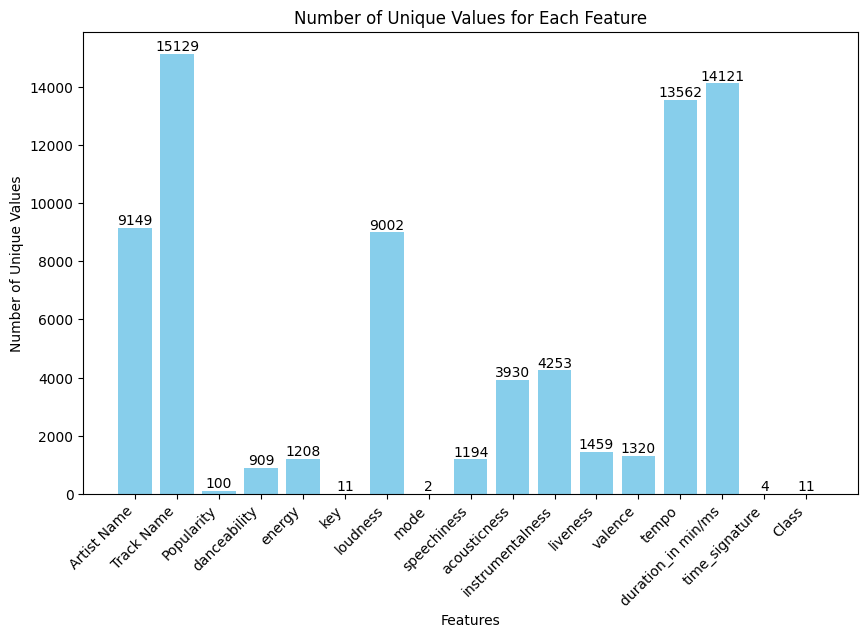

In [6]:
unique_counts = data.nunique()

plt.figure(figsize=(10, 6))
bars = plt.bar(unique_counts.index, unique_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.title('Number of Unique Values for Each Feature')
plt.xlabel('Features')
plt.ylabel('Number of Unique Values')

plt.xticks(rotation=45, ha='right')
plt.show()

Таким образом определим, что признаки 'key', 'mode' и 'time_signature' (помимо Artist Name и Track Name) являются категориальными. 

Посмотрим, как распределены числовые признаки, и есть ли у нас выбросы. 

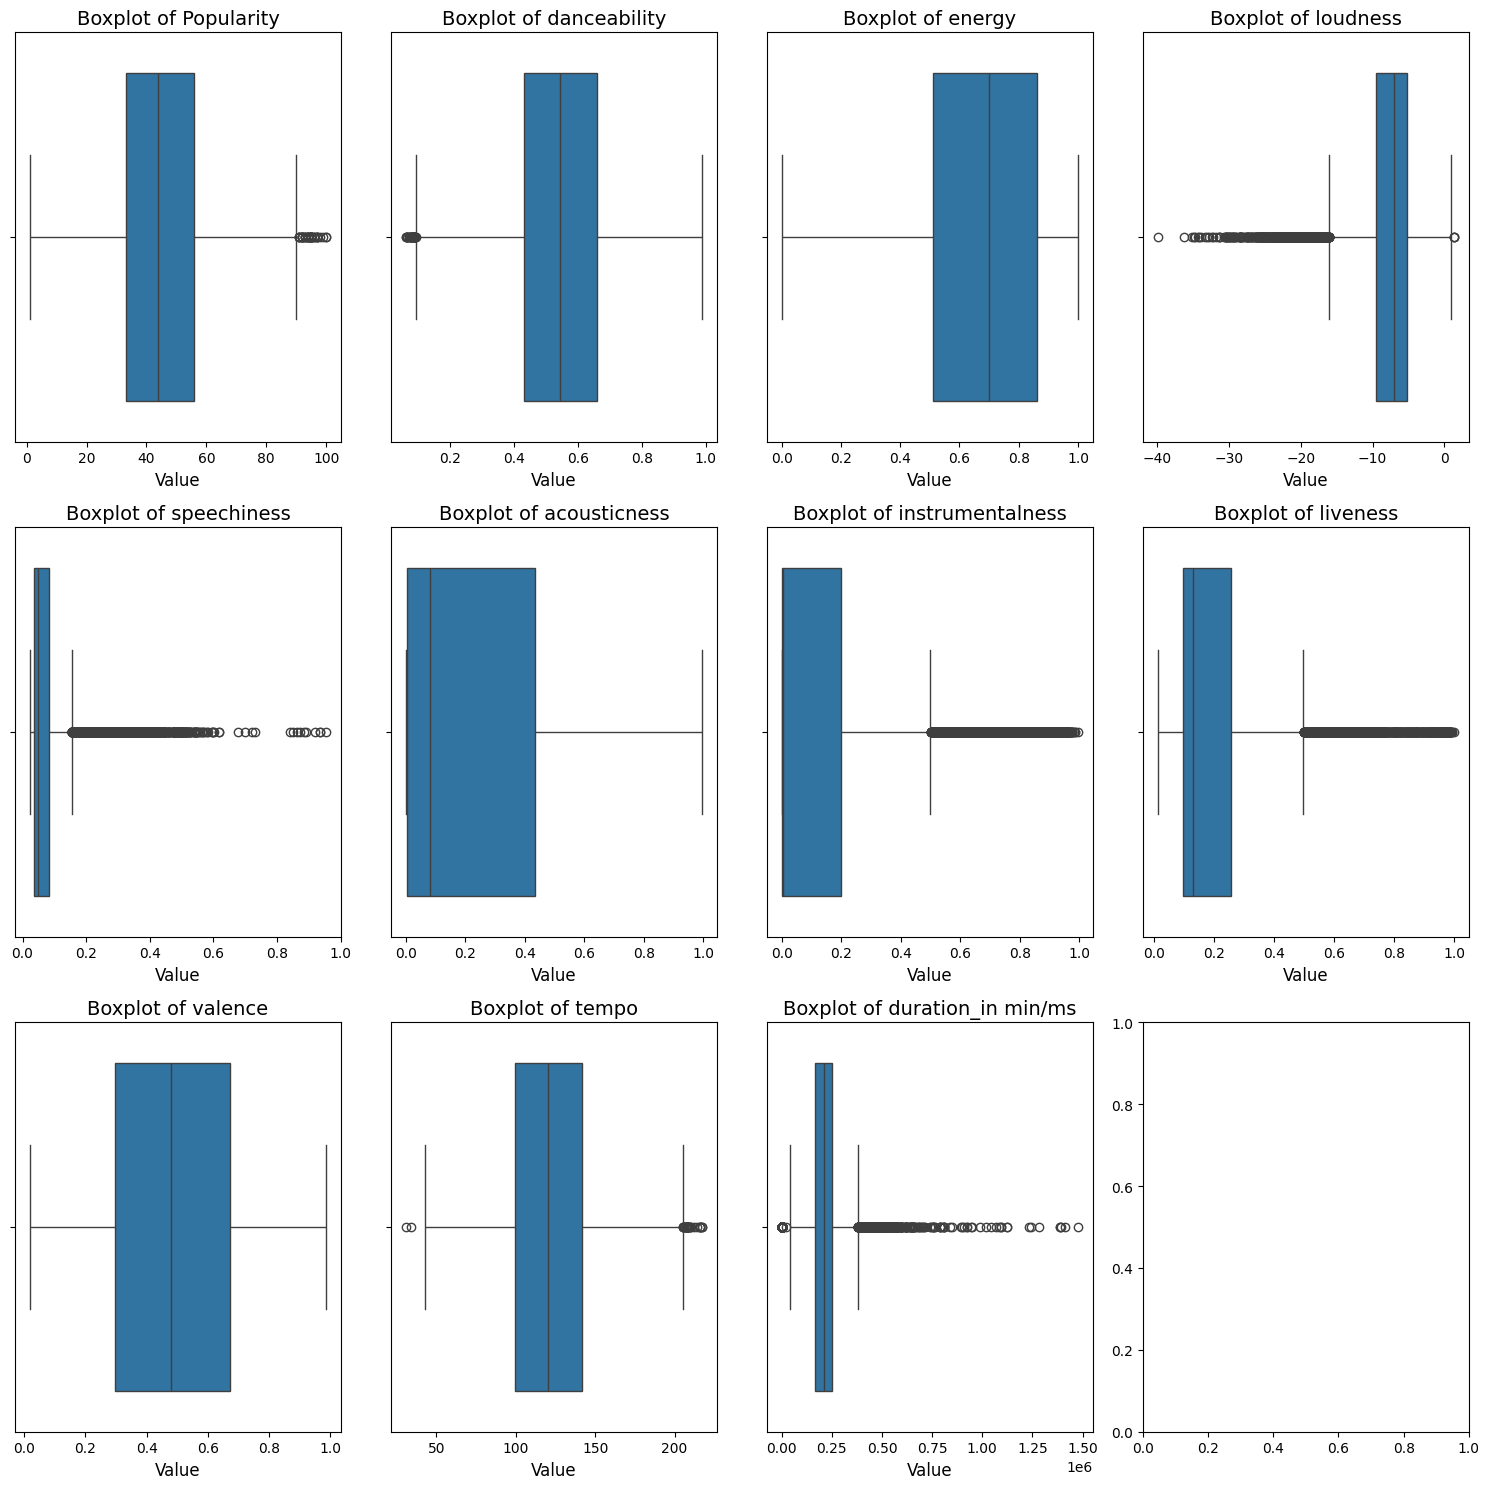

In [7]:
numeric_features = ['Popularity', 'danceability', 'energy', 'loudness', 
                    'speechiness', 'acousticness', 'instrumentalness', 
                    'liveness', 'valence', 'tempo', 'duration_in min/ms']

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

for i in range(3):
    for j in range(4):
        if i * 4 + j < len(numeric_features):
            feature = numeric_features[i * 4 + j]
            sns.boxplot(x=data[feature], ax=axes[i, j])
            axes[i, j].set_title(f"Boxplot of {feature}", fontsize=14)
            axes[i, j].set_xlabel("Value", fontsize=12)

plt.tight_layout()
plt.show()

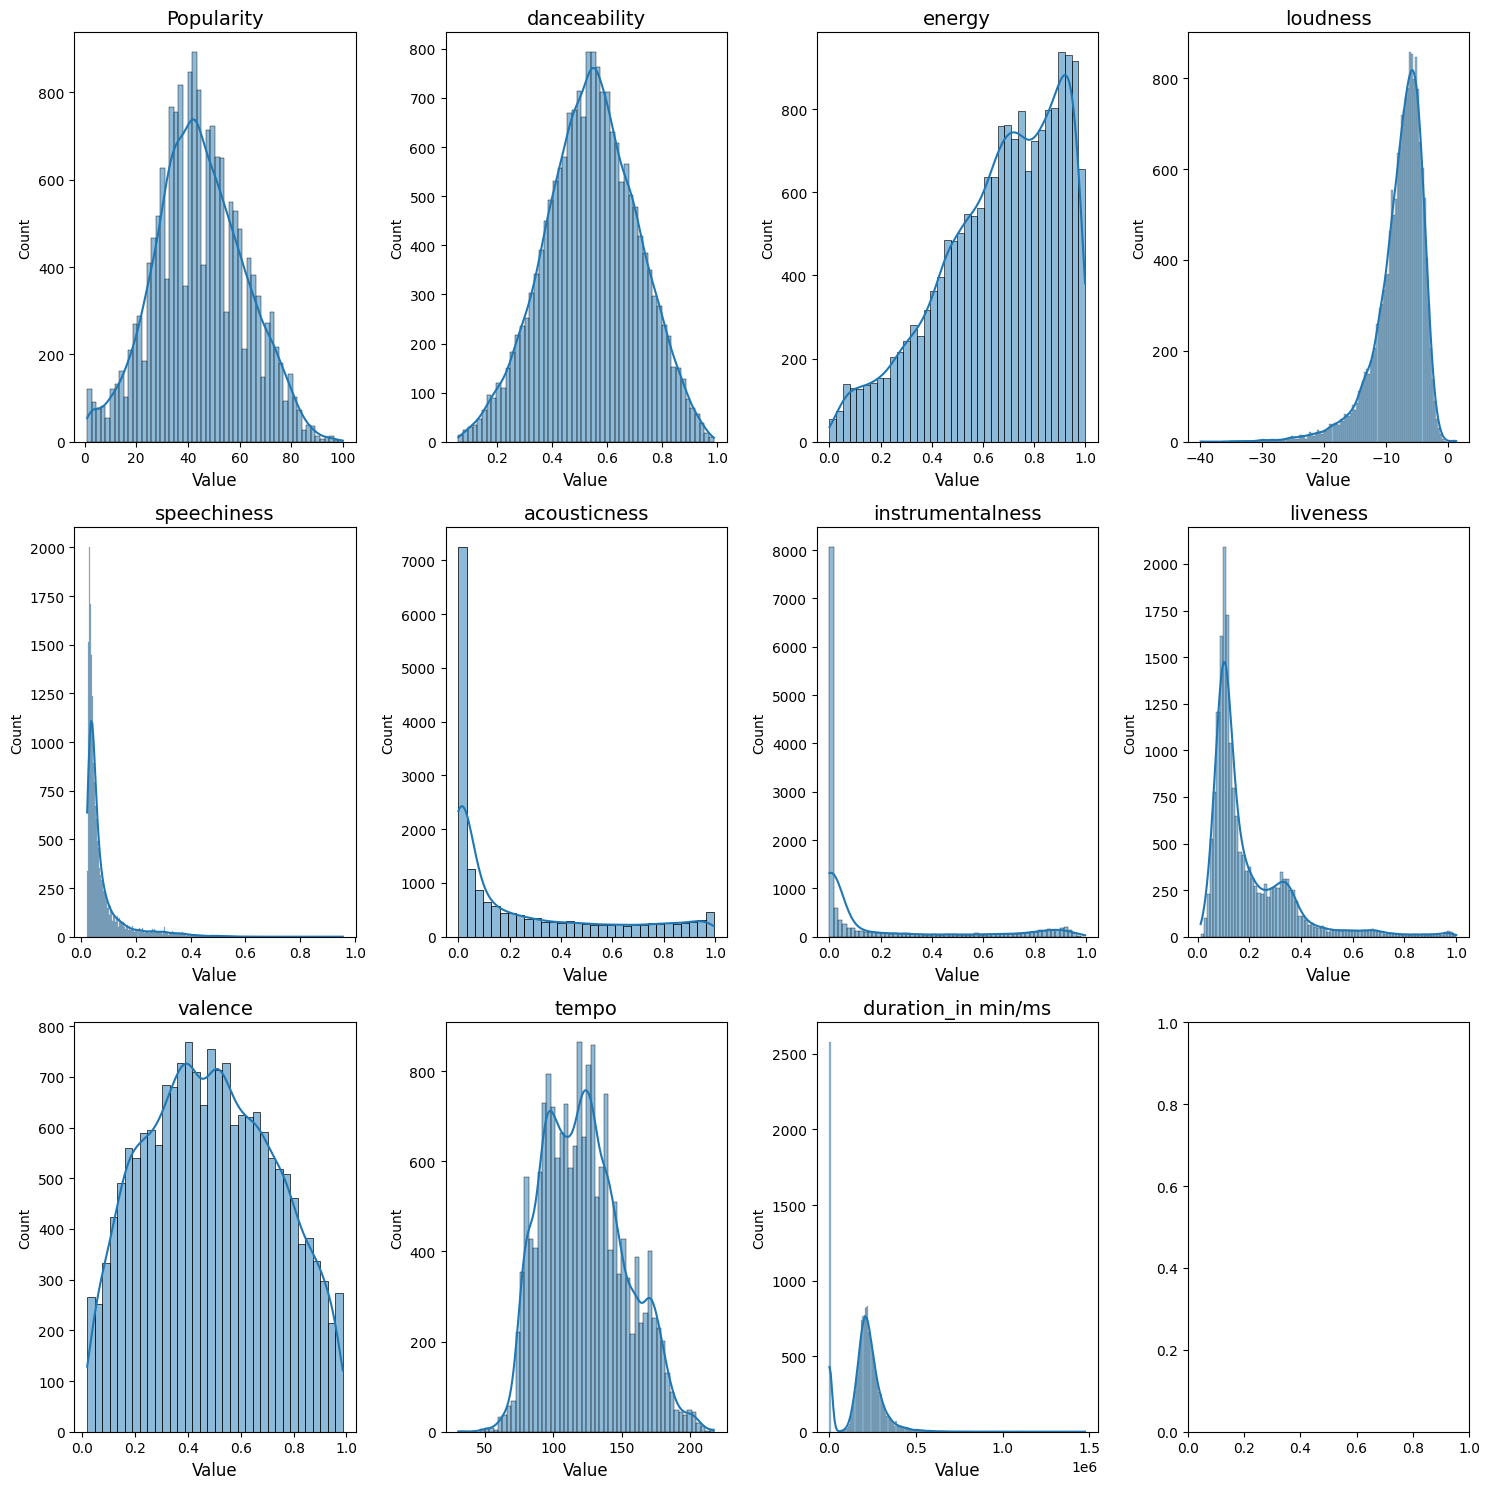

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))

for i in range(3):
    for j in range(4):
        if i * 4 + j < len(numeric_features):
            feature = numeric_features[i * 4 + j]
            sns.histplot(data[feature], kde=True, ax=axes[i, j])
            axes[i, j].set_title(f"{feature}", fontsize=14)
            axes[i, j].set_xlabel("Value", fontsize=12)

plt.tight_layout()
plt.show()

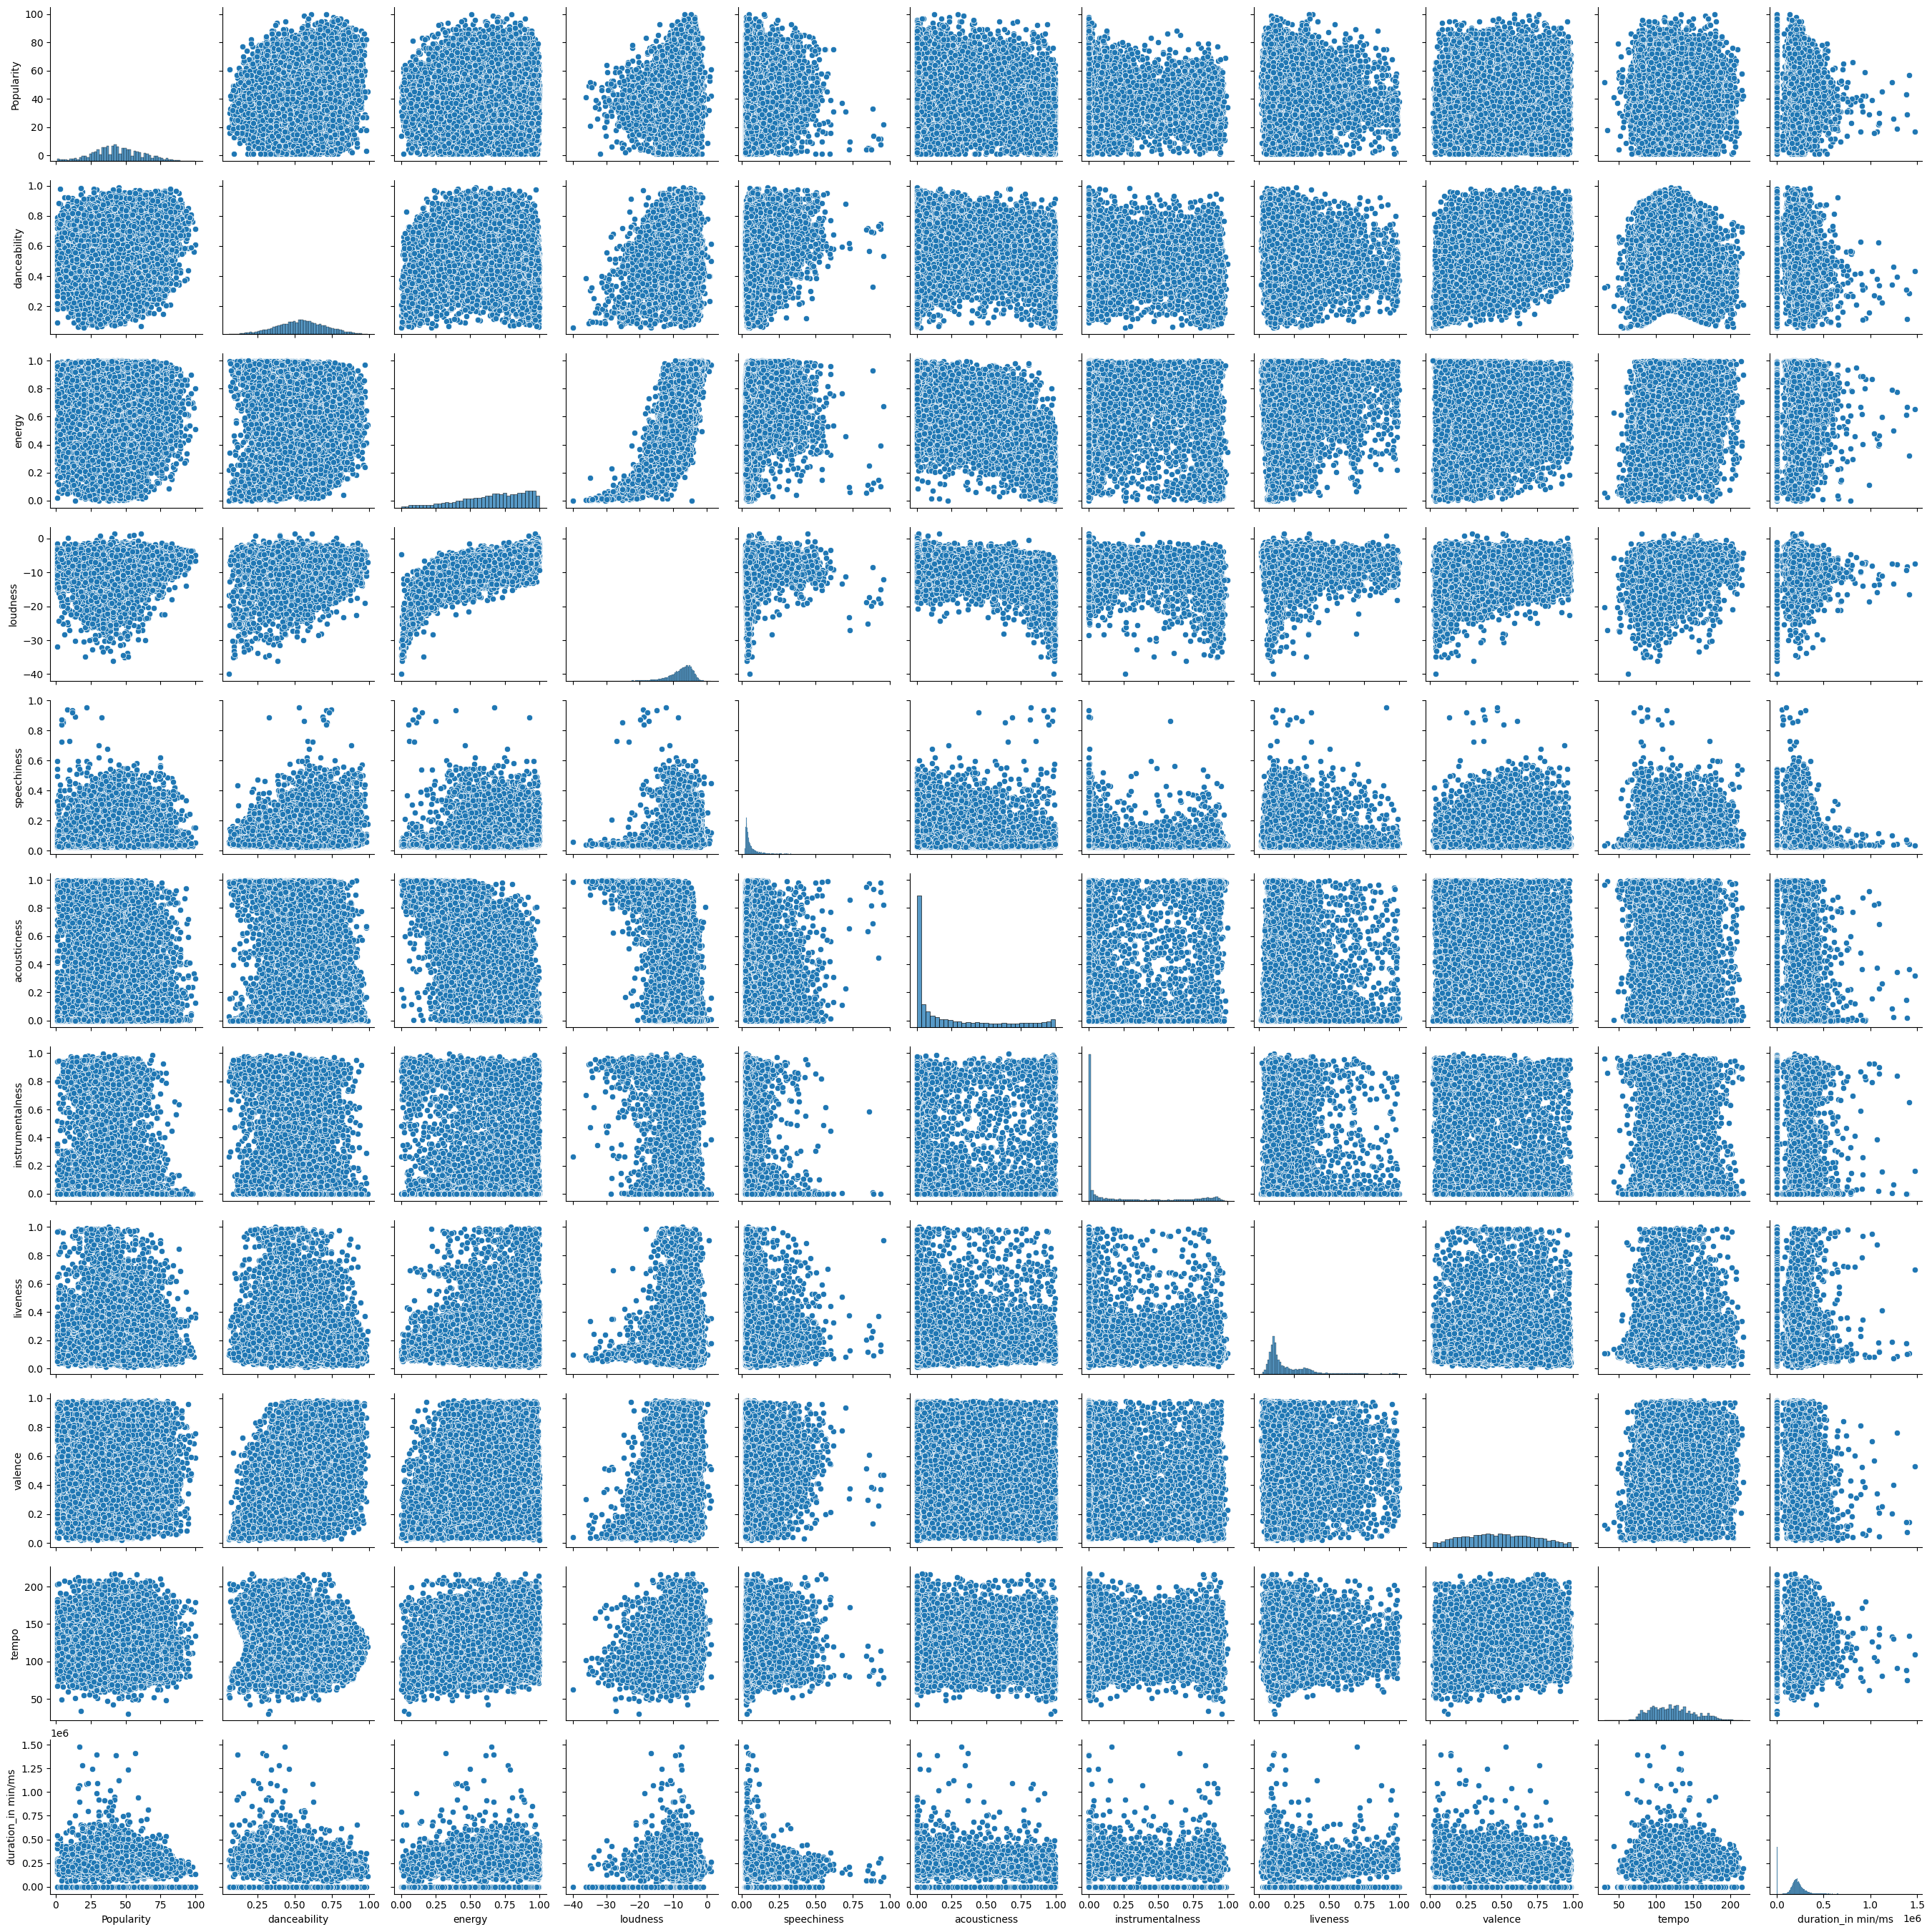

In [9]:
sns.pairplot(data[numeric_features])
plt.show()

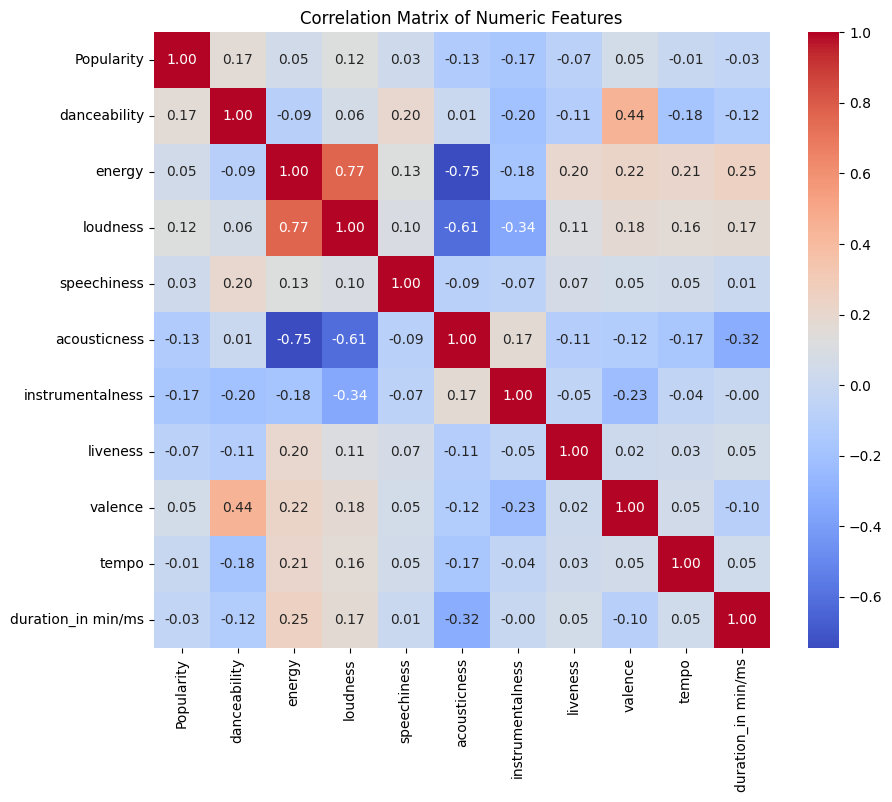

In [10]:
correlation_matrix = data[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

По итогу, мы имеем 
1. категориальные признаки, которые необходимо перекодировать;

2. много пропущенных значений, которые нужно либо выбросить (в таком случае мы потеряем примерно 1/5 данных) или заменить на среднее/медианное значение. А так же можно наблюдать некоторые выбросы, но на мой взгляд большая часть данных распределена нормально и избавляться от выбросов я не буду;

3. довольно высокая корреляция между признаками energy и loudness, energy и acousticness, loudness и acousticness, что довольно логично. Но в контексте дерева решений это не критично.

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [11]:
# Разделим данные. За одно уберем столбцы 'Artist Name', 'Track Name', так как на мой взгляд
# они не должны влиять на предсказания, т.к. слишком много уникальных значений
X = data.drop(columns=['Class', 'Artist Name', 'Track Name'])
y = data['Class']

#### Missing values

In [12]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imp.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

print(X_imputed.isna().sum())

Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
dtype: int64


#### One-Hot Encoding

In [13]:
categorical_features = ['key', 'time_signature']
encoded_X = pd.get_dummies(X_imputed, columns=categorical_features, dtype=int, drop_first=True)
encoded_X.head()

Popularity  danceability  energy  loudness  mode  speechiness  \
0        60.0         0.854   0.564    -4.964   1.0       0.0485   
1        54.0         0.382   0.814    -7.230   1.0       0.0406   
2        35.0         0.434   0.614    -8.334   1.0       0.0525   
3        66.0         0.853   0.597    -6.528   0.0       0.0555   
4        53.0         0.167   0.975    -4.279   1.0       0.2160   

   acousticness  instrumentalness  liveness  valence  ...  \
0      0.017100          0.177562    0.0849   0.8990  ...   
1      0.001100          0.004010    0.1010   0.5690  ...   
2      0.486000          0.000196    0.3940   0.7870  ...   
3      0.021200          0.177562    0.1220   0.5690  ...   
4      0.000169          0.016100    0.1720   0.0918  ...   

   key_5.952446502315104  key_6.0  key_7.0  key_8.0  key_9.0  key_10.0  \
0                      0        0        0        0        0         0   
1                      0        0        0        0        0         0   
2                      0        1        0        0        0         0   
3                      0        0        0        0        0         1   
4                      0        0        0        0        0         0   

   key_11.0  time_signature_3.0  time_signature_4.0  time_signature_5.0  
0         0                   0                   1                   0  
1         0                   0                   1                   0  
2         0                   0                   1                   0  
3         0                   0                   1                   0  
4         0                   0                   1                   0  

[5 rows x 26 columns]

#### Decision tree model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)

# clf = clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [15]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 10, 12, 15, 30],
    'min_samples_split': [2, 5, 7, 10, 12, 15, 30],
    'min_samples_leaf': [1, 3, 5, 7]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best params:", best_params)

Best params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 30}


In [16]:
best_tree_model = DecisionTreeClassifier(random_state=42, **best_params)
best_tree_model.fit(X_train, y_train)

y_pred = best_tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", accuracy)
print("F1-score:", f1)

Accuracy: 0.4722222222222222
F1-score: 0.5107200158653759


In [17]:
from sklearn import tree

text_representation = tree.export_text(best_tree_model)
print(text_representation)

|--- feature_11 <= 20334.94
|   |--- feature_7 <= 0.44
|   |   |--- feature_6 <= 0.42
|   |   |   |--- feature_0 <= 44.76
|   |   |   |   |--- feature_3 <= -7.19
|   |   |   |   |   |--- feature_8 <= 0.61
|   |   |   |   |   |   |--- feature_9 <= 0.59
|   |   |   |   |   |   |   |--- feature_3 <= -10.56
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_3 >  -10.56
|   |   |   |   |   |   |   |   |--- feature_6 <= 0.02
|   |   |   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |   |   |   |--- feature_6 >  0.02
|   |   |   |   |   |   |   |   |   |--- feature_8 <= 0.33
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- feature_8 >  0.33
|   |   |   |   |   |   |   |   |   |   |--- class: 9
|   |   |   |   |   |   |--- feature_9 >  0.59
|   |   |   |   |   |   |   |--- feature_11 <= 3.73
|   |   |   |   |   |   |   |   |--- feature_0 <= 32.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   

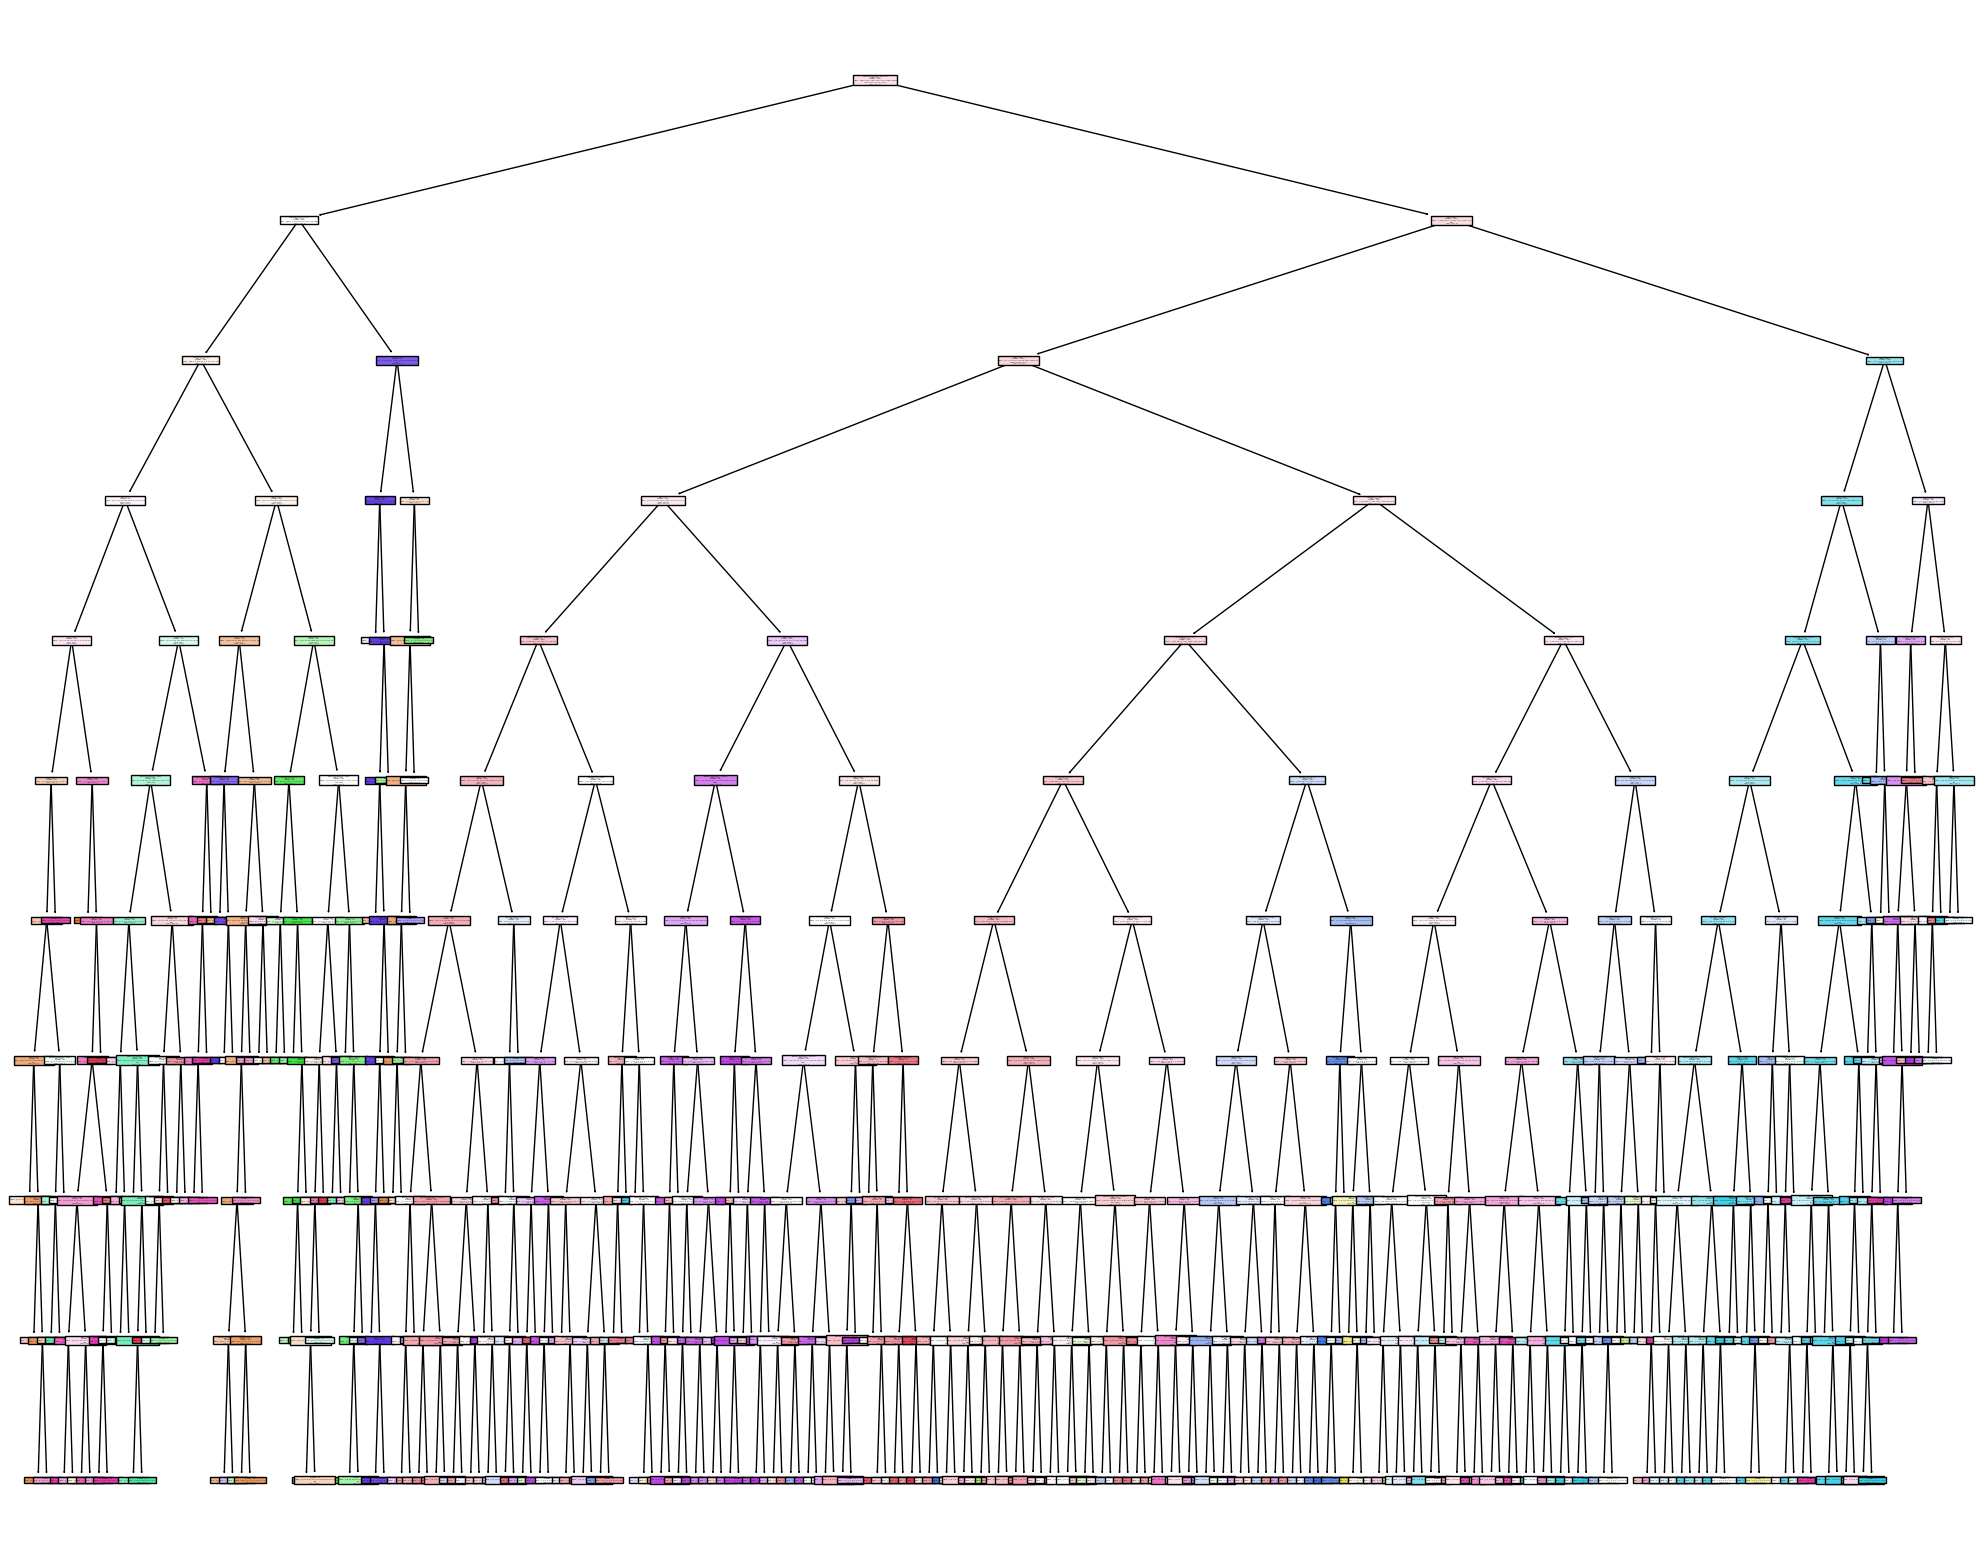

In [18]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25, 20))
_ = plot_tree(best_tree_model, 
              feature_names=encoded_X.columns,  
              class_names = ['class_0', 'class_1', 
                             'class_2', 'class_3', 
                             'class_4', 'class_5', 
                             'class_6', 'class_7', 
                             'class_8', 'class_9', 
                             'class_10'],
              filled=True)
plt.show()

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

Стало ли лучше? Мне - нет.

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. "Она" - как раз про роман с ИИ, как у меня сейчас с МЛ, только смахивает на абьюзивные отношения... 

2. "Реальные упыри" - ну это гениально, маст вотч и вообще, если не смотрели, надо обязательно прям сесть и посмотреть!! И именно в русской озвучке. У меня кстати аватарка в гите с Тайкой Вайтити :)

3. "Офис" - это, конечно, не фильм, а сериал, но такой же легендарный и классный, как реальные упыри. И вообще это самый классный ситком с невероятно тонким юмором!